In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
geo = pd.read_csv('geo-code.csv').iloc[:,[4,5,6]]

In [88]:
covid = pd.read_excel('covid_data.xlsx', sheet_name='covid')
covid = covid.rename(columns = {'Deaths_1M pop':'dth1m'})
covid = covid.loc[:,['Country', 'dth1m', 'Population']]
covid = covid[covid['Population']>= 1000000]
covid.head()

,Country,dth1m,Population
0,Afghanistan,57.0,39379235.0
1,Albania,425.0,2876153.0
2,Algeria,63.0,44259691.0
4,Angola,12.0,33388496.0
7,Argentina,972.0,45411216.0


In [89]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 219
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     156 non-null    object 
 1   dth1m       153 non-null    float64
 2   Population  156 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.9+ KB


In [90]:
covid = covid.dropna(axis=0, subset=['dth1m'])
covid.shape

(153, 3)

In [91]:
covid=covid.merge(geo, how='left', left_on='Country', right_on='Country')

In [92]:
gdp = pd.read_excel('covid_data.xlsx', sheet_name='gdp percap').drop('Unnamed: 0', axis=1)
covid=covid.merge(gdp, how='left', left_on='Country', right_on='Country')

In [93]:
dth_cd = pd.read_excel('covid_data.xlsx', sheet_name='death_communicable')
covid=covid.merge(dth_cd, how='left', left_on='Country', right_on='Country')

In [94]:
youth = pd.read_excel('covid_data.xlsx', sheet_name='youth')
covid=covid.merge(youth, how='left', left_on='Country', right_on='Country')

In [95]:
life = pd.read_excel('covid_data.xlsx', sheet_name='life expectancy').iloc[:,[1,2]]
covid=covid.merge(life, how='left', left_on='Country', right_on='Country')

In [96]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 152
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          153 non-null    object 
 1   dth1m            153 non-null    float64
 2   Population       153 non-null    float64
 3   world_4region    153 non-null    object 
 4   world_6region    153 non-null    object 
 5   GDPpc_PPP        147 non-null    float64
 6   GDPpc_nominal    148 non-null    float64
 7   dth_cd           150 non-null    float64
 8   youth            146 non-null    float64
 9   Life Expectancy  152 non-null    float64
dtypes: float64(7), object(3)
memory usage: 13.1+ KB


### Exploratory Analysis

<Figure size 1080x576 with 0 Axes>

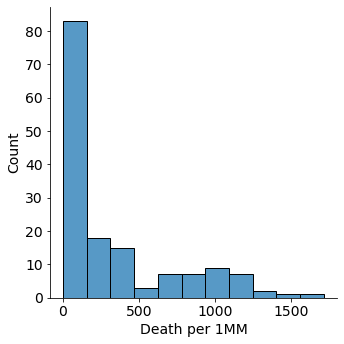

In [97]:
#plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15,8))
sns.displot(covid['dth1m'])
plt.xlabel('Death per 1MM')
plt.savefig('dth1mm distribution.png')
plt.show()

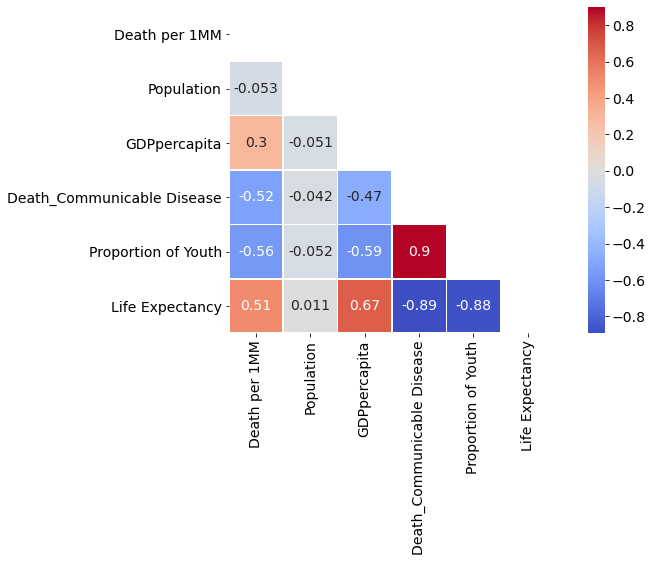

In [98]:
### Correlation Analysis

dfn = covid.select_dtypes(exclude=object)
dfn = dfn.drop(['GDPpc_PPP'], axis=1)
list(dfn.columns)
cols = ['Death per 1MM', 'Population', 'GDPpercapita', 'Death_Communicable Disease', 'Proportion of Youth', 'Life Expectancy']
dfn.columns = cols

plt.figure(figsize=(12,6))
corr_back = dfn.corr()
mask = np.zeros_like(corr_back, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_back, mask=mask, center=0, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.savefig('corr.png', bbox_inches = 'tight')
plt.show()

### Deaths per 1MM vs Region

In [99]:
rg = covid.groupby('world_4region')['dth1m'].agg('mean')
rg

world_4region
Africa       51.822449
Americas    505.625000
Asia        111.057500
Europe      726.225000
Name: dth1m, dtype: float64

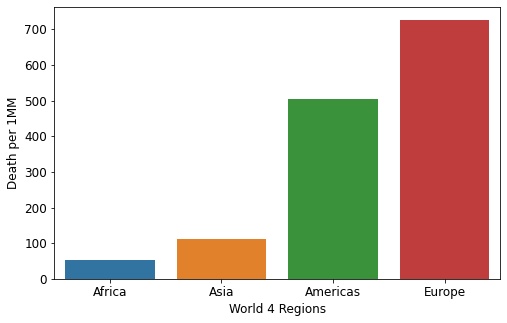

In [100]:
rg.sort_values(inplace=True)
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 12})
sns.barplot(x = rg.index, y = rg)
plt.ylabel('Death per 1MM')
plt.xlabel('World 4 Regions')
plt.savefig('world 4 regions.png')
plt.show()

In [101]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
mod = ols('dth1m ~ world_4region', data=covid).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print (aov_table)

                     sum_sq     df        F        PR(>F)
world_4region  1.269390e+07    3.0  53.1269  2.067424e-23
Residual       1.186713e+07  149.0      NaN           NaN


In [102]:
rg = covid.groupby('world_6region')['dth1m'].agg('mean')
rg

world_6region
America                     505.625000
East_Asia_Pacific            22.518750
Europe_Central_Asia         668.250000
Middle_East_North_Africa    231.052632
South_Asia                   55.833333
Sub_Saharan_Africa           35.052273
Name: dth1m, dtype: float64

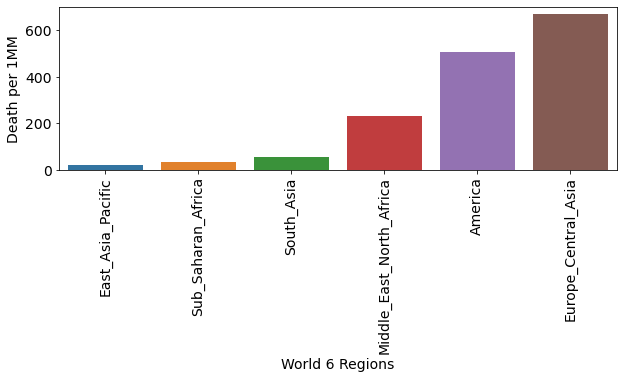

In [103]:
rg.sort_values(inplace=True)
plt.figure(figsize=(10,3))
plt.rcParams.update({'font.size': 14})
sns.barplot(x = rg.index, y = rg)
plt.ylabel('Death per 1MM')
plt.xticks(rotation=90)
plt.xlabel('World 6 Regions')
plt.savefig('world 6 regions.png', bbox_inches = 'tight')
plt.show()

In [104]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
mod = ols('dth1m ~ world_6region', data=covid).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print (aov_table)

                     sum_sq     df          F        PR(>F)
world_6region  1.171661e+07    5.0  26.818488  3.323282e-19
Residual       1.284443e+07  147.0        NaN           NaN


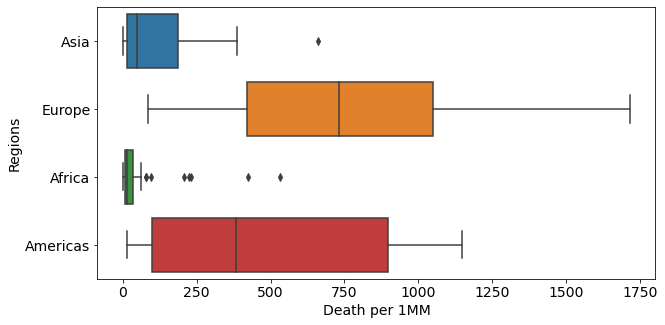

In [105]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 14})
sns.boxplot(x='dth1m', y='world_4region', data=covid).set(xlabel='Death per 1MM', ylabel='Regions')
plt.savefig('world 4 regions boxplot.png', bbox_inches = 'tight')
plt.show()

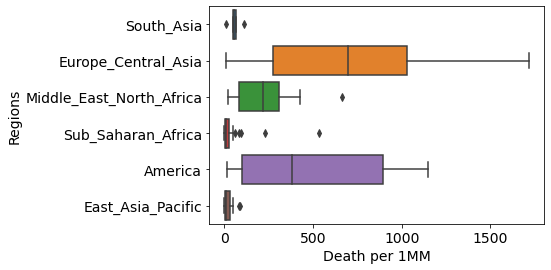

In [106]:
sns.boxplot(x='dth1m', y='world_6region', data=covid).set(xlabel='Death per 1MM', ylabel='Regions')
plt.show()

### Deaths per 1MM vs Percapita GDP

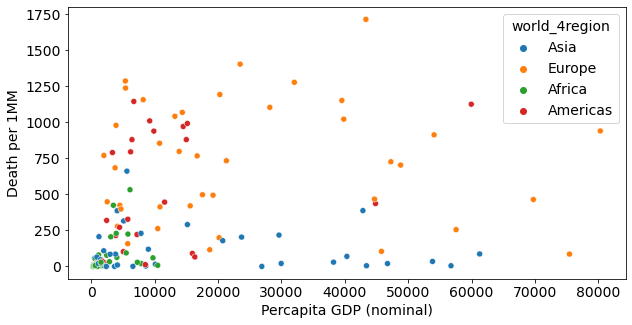

In [107]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 14})
sns.scatterplot(x='GDPpc_nominal', y='dth1m', hue='world_4region', data=covid)
plt.xlabel('Percapita GDP (nominal)')
plt.ylabel('Death per 1MM')
plt.savefig('percapita gdp nominal.png', bbox_inches = 'tight')
plt.show()

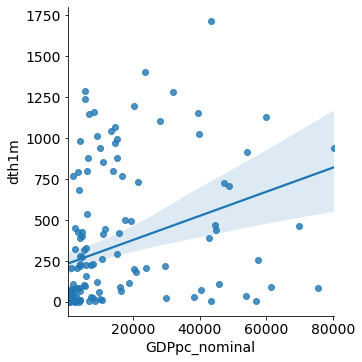

In [108]:
covid2 = covid.dropna()
sns.lmplot(x='GDPpc_nominal', y='dth1m', data=covid2)
plt.show()

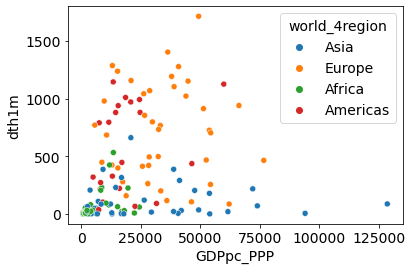

In [109]:
sns.scatterplot(x='GDPpc_PPP', y='dth1m', hue='world_4region', data=covid)
plt.show()

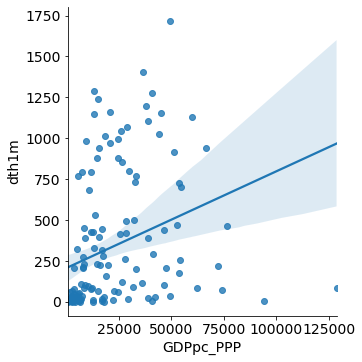

In [110]:
covid2 = covid.dropna()
sns.lmplot(x='GDPpc_PPP', y='dth1m', data=covid2)
plt.show()

In [111]:
import statsmodels.api as sm
covid2 = covid.dropna()
X = covid2['GDPpc_nominal']
Xc = sm.add_constant(X)
y = covid2['dth1m']
model = sm.OLS(y, Xc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dth1m   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     16.44
Date:                Tue, 12 Jan 2021   Prob (F-statistic):           8.27e-05
Time:                        09:23:25   Log-Likelihood:                -1054.3
No. Observations:                 143   AIC:                             2113.
Df Residuals:                     141   BIC:                             2119.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           230.4827     40.552      5.684      0.000     150.313     310.652
GDPpc_nominal     0.0074      0.002      4.055      0.000       0.004       0.011
==============================================================================
Omnibus:                       23.046   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.938
Skew:                           1.084   Prob(JB):                     5.20e-07
Kurtosis:                       3.393   Cond. No.                     2.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [112]:
y_pred = model.predict(Xc)

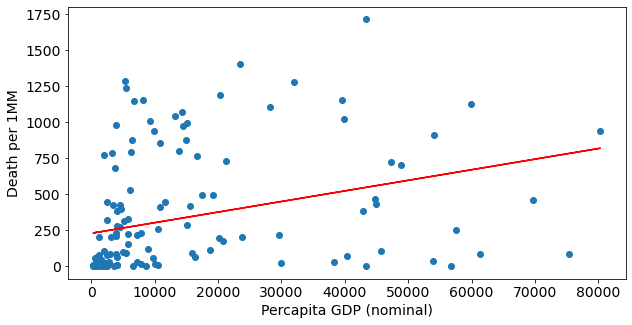

In [113]:
plt.figure(figsize=(10,5))
plt.plot(X, y_pred, 'r')
plt.scatter(X, y)
plt.xlabel('Percapita GDP (nominal)')
plt.ylabel('Death per 1MM')
plt.savefig('gdp regression.png', bbox_inches = 'tight')
plt.show()

In [114]:
covid2 = covid2.copy()
ser, bins = pd.qcut(covid2['GDPpc_nominal'], 4, retbins=True, labels=False)
covid2.loc[:,'gdp_group'] = pd.cut(covid2['GDPpc_nominal'], bins=bins)
covid2.head()

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy,gdp_group
0,Afghanistan,57.0,39379235.0,Asia,South_Asia,1976.0,538.0,36.4,42.472271,65.98,"(293.0, 1559.0]"
1,Albania,425.0,2876153.0,Europe,Europe_Central_Asia,12943.0,4521.0,2.9,17.399564,78.96,"(1559.0, 5387.0]"
2,Algeria,63.0,44259691.0,Africa,Middle_East_North_Africa,15293.0,4048.0,14.8,30.550379,77.50,"(1559.0, 5387.0]"
3,Angola,12.0,33388496.0,Africa,Sub_Saharan_Africa,6658.0,4096.0,63.4,46.622025,62.22,"(1559.0, 5387.0]"
4,Argentina,972.0,45411216.0,Americas,America,20829.0,14508.0,15.9,24.595526,77.17,"(5387.0, 16146.5]"


In [115]:
gd = covid2.groupby('gdp_group')['dth1m'].agg('mean')

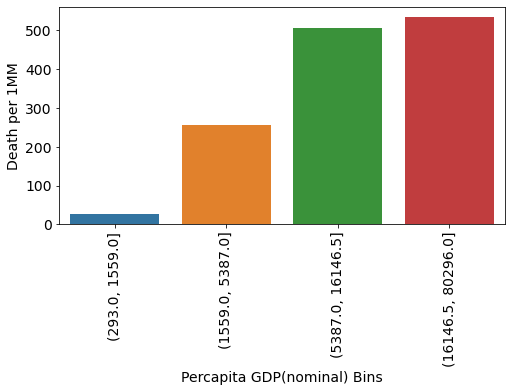

In [128]:
#rg.sort_values(inplace=True)
#plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 4))
sns.barplot(x = gd.index, y = gd)
plt.ylabel('Death per 1MM')
plt.xlabel('Percapita GDP(nominal) Bins')
plt.xticks(rotation=90)
plt.savefig('gdp barplot.png', bbox_inches = 'tight')
plt.show()

In [117]:
mod = ols('dth1m ~ gdp_group', data=covid2).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print (aov_table)

                 sum_sq     df          F        PR(>F)
gdp_group  6.049213e+06    3.0  15.860643  6.458200e-09
Residual   1.754429e+07  138.0        NaN           NaN


### Deaths per 1MM vs Proportion of Youth in Population

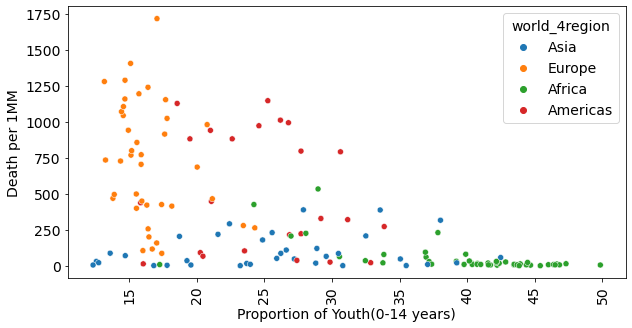

In [118]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='youth', y='dth1m', hue='world_4region', data=covid)
plt.ylabel('Death per 1MM')
plt.xlabel('Proportion of Youth(0-14 years)')
plt.xticks(rotation=90)
plt.savefig('youth scatterplot.png', bbox_inches = 'tight')
plt.show()

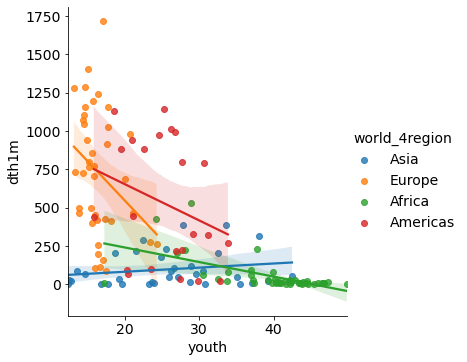

In [119]:
covid2 = covid.dropna()
sns.lmplot(x='youth', y='dth1m', hue='world_4region', data=covid2)
plt.show()

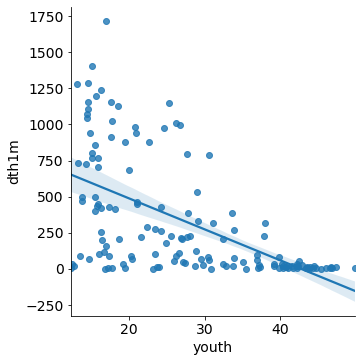

In [120]:
covid2 = covid.dropna()
sns.lmplot(x='youth', y='dth1m', data=covid2)
plt.show()

In [121]:
import statsmodels.api as sm
covid2 = covid.dropna()
X = covid2['youth']
Xc = sm.add_constant(X)
y = covid2['dth1m']
model = sm.OLS(y, Xc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dth1m   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     67.25
Date:                Tue, 12 Jan 2021   Prob (F-statistic):           1.33e-13
Time:                        09:23:27   Log-Likelihood:                -1034.3
No. Observations:                 143   AIC:                             2073.
Df Residuals:                     141   BIC:                             2079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        919.0605     77.271     11.894      0.000     766.300    1071.821
youth        -21.5101      2.623     -8.201      0.000     -26.695     -16.325
==============================================================================
Omnibus:                       10.739   Durbin-Watson:                   2.324
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.912
Skew:                           0.642   Prob(JB):                      0.00427
Kurtosis:                       3.430   Cond. No.                         80.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

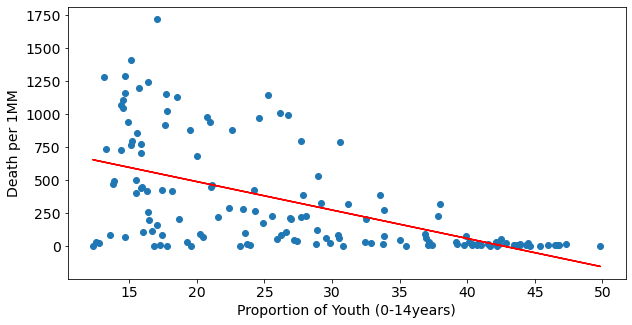

In [122]:
y_pred = model.predict(Xc)

plt.figure(figsize=(10,5))
plt.plot(X, y_pred, 'r')
plt.scatter(X, y)
plt.xlabel('Proportion of Youth (0-14years)')
plt.ylabel('Death per 1MM')
plt.savefig('youth regression plot.png')
plt.show()

In [123]:
covid3 = covid.copy()
ser, bins = pd.qcut(covid3['youth'], 4, retbins=True, labels=False)
covid3.loc[:,'youth_group'] = pd.cut(covid3['youth'], bins=bins)
covid3.head()

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy,youth_group
0,Afghanistan,57.0,39379235.0,Asia,South_Asia,1976.0,538.0,36.4,42.472271,65.98,"(37.715, 49.842]"
1,Albania,425.0,2876153.0,Europe,Europe_Central_Asia,12943.0,4521.0,2.9,17.399564,78.96,"(17.109, 26.2]"
2,Algeria,63.0,44259691.0,Africa,Middle_East_North_Africa,15293.0,4048.0,14.8,30.550379,77.50,"(26.2, 37.715]"
3,Angola,12.0,33388496.0,Africa,Sub_Saharan_Africa,6658.0,4096.0,63.4,46.622025,62.22,"(37.715, 49.842]"
4,Argentina,972.0,45411216.0,Americas,America,20829.0,14508.0,15.9,24.595526,77.17,"(17.109, 26.2]"


In [124]:
yh = covid3.groupby('youth_group')['dth1m'].agg('mean')

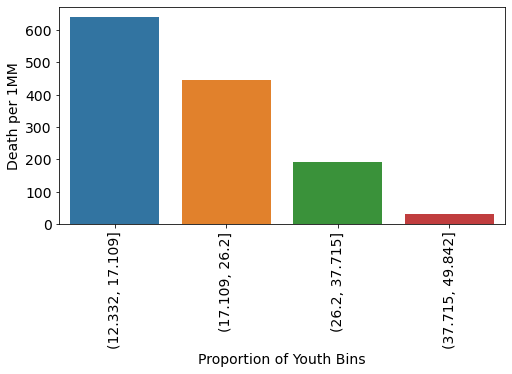

In [127]:
#rg.sort_values(inplace=True)
#plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 4))
sns.barplot(x = yh.index, y = yh)
plt.ylabel('Death per 1MM')
plt.xlabel('Proportion of Youth Bins')
plt.xticks(rotation=90)
plt.savefig('youth barplot.png', bbox_inches = 'tight')
plt.show()

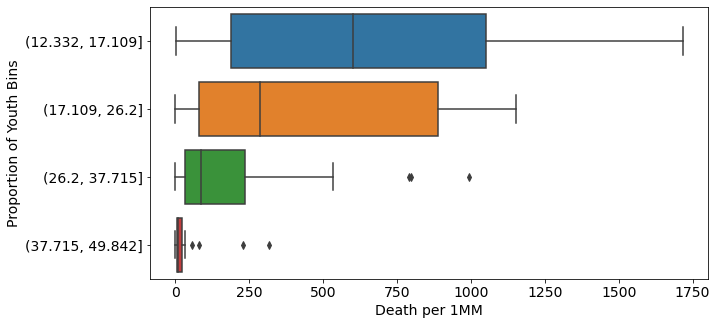

In [43]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 14})
sns.boxplot(x='dth1m', y='youth_group', data=covid3).set(xlabel='Death per 1MM', ylabel='Proportion of Youth Bins')
plt.savefig('youth boxplot.png', bbox_inches = 'tight')
plt.show()

### Deaths per 1MM vs Incidence of Death due to Communicable Diseases

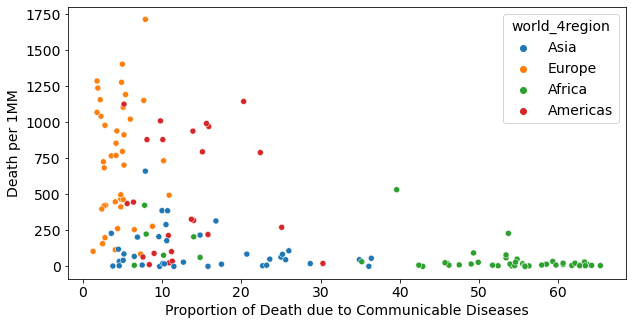

In [44]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='dth_cd', y='dth1m', hue='world_4region', data=covid)
plt.ylabel('Death per 1MM')
plt.xlabel('Proportion of Death due to Communicable Diseases')
plt.savefig('death comm scatterplot.png', bbox_inches = 'tight')
plt.show()

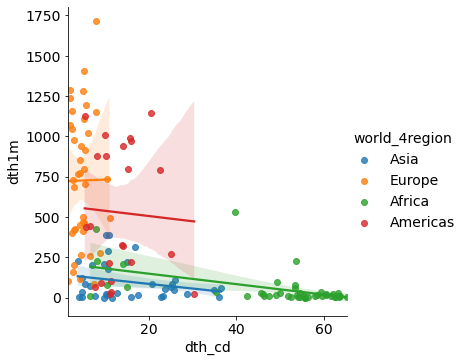

In [45]:
covid2 = covid.dropna()
sns.lmplot(x='dth_cd', y='dth1m', hue='world_4region', data=covid2)
plt.show()

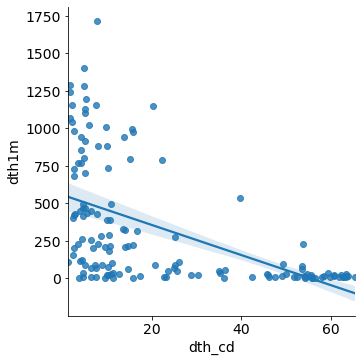

In [46]:
covid2 = covid.dropna()
sns.lmplot(x='dth_cd', y='dth1m', data=covid2)
plt.show()

In [47]:
import statsmodels.api as sm
covid2 = covid.dropna()
X = covid2['dth_cd']
Xc = sm.add_constant(X)
y = covid2['dth1m']
model2 = sm.OLS(y, Xc).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dth1m   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     53.45
Date:                Sun, 10 Jan 2021   Prob (F-statistic):           1.81e-11
Time:                        15:51:59   Log-Likelihood:                -1039.2
No. Observations:                 143   AIC:                             2082.
Df Residuals:                     141   BIC:                             2088.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        556.7416     42.683     13.044      0.000     472.360     641.123
dth_cd       -10.0651      1.377     -7.311      0.000     -12.787      -7.343
==============================================================================
Omnibus:                       16.848   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.060
Skew:                           0.869   Prob(JB):                     7.26e-05
Kurtosis:                       3.421   Cond. No.                         45.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

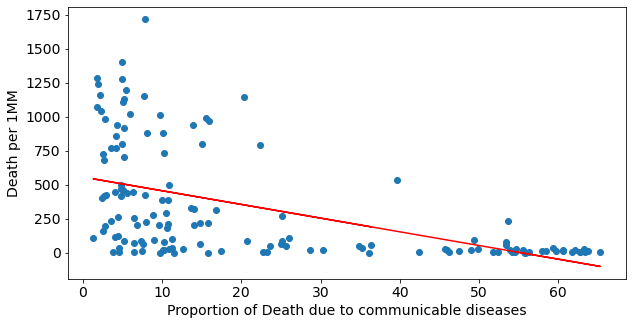

In [48]:
y_pred = model2.predict(Xc)

plt.figure(figsize=(10,5))
plt.plot(X, y_pred, 'r')
plt.scatter(X, y)
plt.xlabel('Proportion of Death due to communicable diseases')
plt.ylabel('Death per 1MM')
plt.savefig('comm dis regression plot.png')
plt.show()

In [49]:
covid3 = covid.copy()
ser, bins = pd.qcut(covid3['dth_cd'], 4, retbins=True, labels=False)
covid3.loc[:,'dth_cd_group'] = pd.cut(covid3['dth_cd'], bins=bins)
covid3.head()

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy,dth_cd_group
0,Afghanistan,57.0,39379235.0,Asia,South_Asia,1976.0,538.0,36.4,42.472271,65.98,"(11.25, 45.925]"
1,Albania,425.0,2876153.0,Europe,Europe_Central_Asia,12943.0,4521.0,2.9,17.399564,78.96,"(1.3, 5.2]"
2,Algeria,63.0,44259691.0,Africa,Middle_East_North_Africa,15293.0,4048.0,14.8,30.550379,77.50,"(11.25, 45.925]"
3,Angola,12.0,33388496.0,Africa,Sub_Saharan_Africa,6658.0,4096.0,63.4,46.622025,62.22,"(45.925, 65.3]"
4,Argentina,972.0,45411216.0,Americas,America,20829.0,14508.0,15.9,24.595526,77.17,"(11.25, 45.925]"


In [50]:
dth = covid3.groupby('dth_cd_group')['dth1m'].agg('mean')

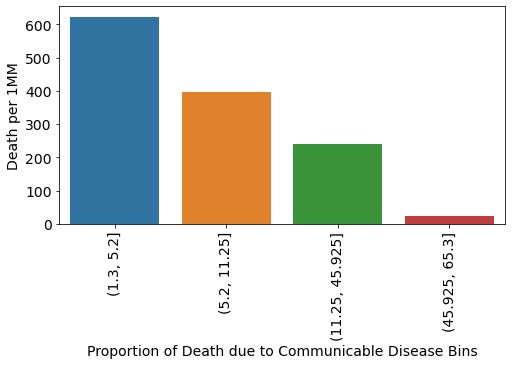

In [51]:
#rg.sort_values(inplace=True)
#plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 4))
sns.barplot(x = dth.index, y = dth)
plt.ylabel('Death per 1MM')
plt.xlabel('Proportion of Death due to Communicable Disease Bins')
plt.xticks(rotation=90)
plt.savefig('dth_cd barplot.png', bbox_inches = 'tight')
plt.show()

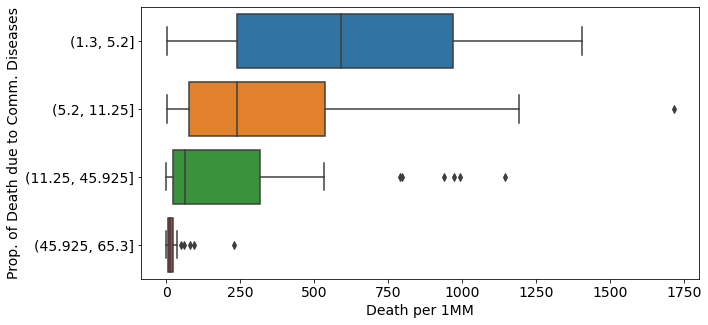

In [52]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 14})
sns.boxplot(x='dth1m', y='dth_cd_group', data=covid3).set(xlabel='Death per 1MM', 
                            ylabel='Prop. of Death due to Comm. Diseases')
plt.savefig('dth_cd boxplot.png', bbox_inches = 'tight')
plt.show()

### Deaths per 1MM vs Life Expectancy

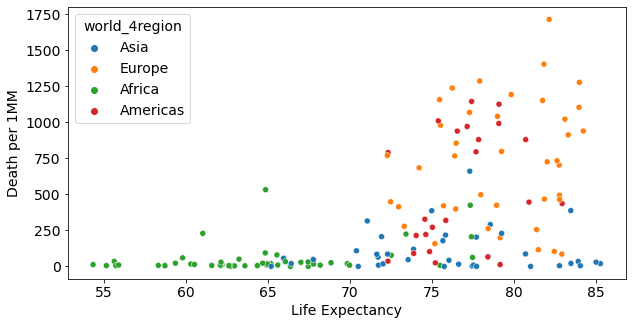

In [53]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='Life Expectancy', y='dth1m', hue='world_4region', data=covid)
plt.ylabel('Death per 1MM')
plt.xlabel('Life Expectancy')
plt.savefig('life exp scatterplot.png', bbox_inches = 'tight')
plt.show()

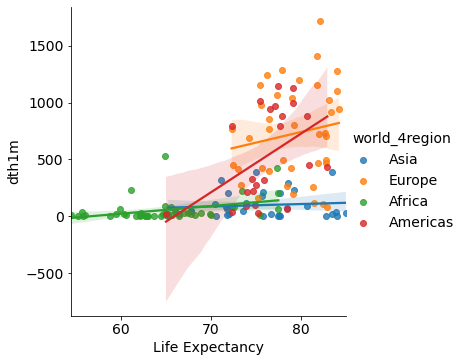

In [54]:
covid2 = covid.dropna()
sns.lmplot(x='Life Expectancy', y='dth1m', hue='world_4region', data=covid2)
plt.show()

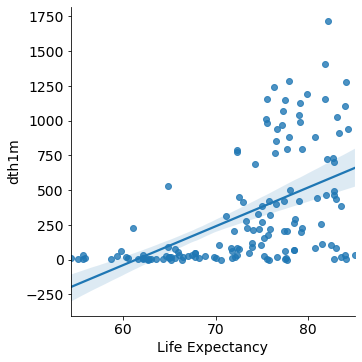

In [55]:
covid2 = covid.dropna()
sns.lmplot(x='Life Expectancy', y='dth1m', data=covid2)
plt.show()

In [56]:
import statsmodels.api as sm
covid2 = covid.dropna()
X = covid2[['Life Expectancy']]
Xc = sm.add_constant(X)
y = np.log(covid2['dth1m'])
model = sm.OLS(y, Xc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dth1m   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     71.06
Date:                Sun, 10 Jan 2021   Prob (F-statistic):           3.65e-14
Time:                        15:52:01   Log-Likelihood:                -278.52
No. Observations:                 143   AIC:                             561.0
Df Residuals:                     141   BIC:                             567.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.0676      1.375     -5.139      0.000      -9.786      -4.349
Life Expectancy     0.1575      0.019      8.430      0.000       0.121       0.194
==============================================================================
Omnibus:                       30.814   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.901
Skew:                          -1.162   Prob(JB):                     2.93e-10
Kurtosis:                       4.404   Cond. No.                         708.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
y_pred = np.exp(-7+ 0.1588*covid2['Life Expectancy'])

E:\anaconda3\envs\py37\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
E:\anaconda3\envs\py37\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


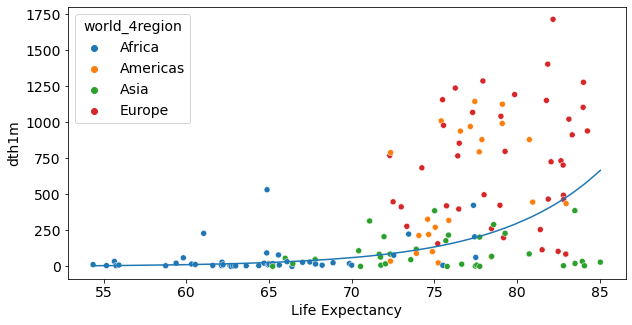

In [58]:
#covid2 = covid.copy()
plt.figure(figsize=(10, 5))
covid2.loc[:,'y_pred'] = y_pred
covid2 = covid2.sort_values(by='Life Expectancy')
sns.scatterplot(x='Life Expectancy', y='dth1m', hue='world_4region', data=covid2)
plt.plot(covid2['Life Expectancy'], covid2['y_pred'])
plt.savefig('life exp regplot.png', bbox_inches = 'tight')
plt.show()

In [59]:
covid3 = covid.copy()
ser, bins = pd.qcut(covid3['Life Expectancy'], 4, retbins=True, labels=False)
covid3.loc[:,'life_group'] = pd.cut(covid3['Life Expectancy'], bins=bins)
covid3.head()

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy,life_group
0,Afghanistan,57.0,39379235.0,Asia,South_Asia,1976.0,538.0,36.4,42.472271,65.98,"(54.36, 66.428]"
1,Albania,425.0,2876153.0,Europe,Europe_Central_Asia,12943.0,4521.0,2.9,17.399564,78.96,"(75.125, 78.975]"
2,Algeria,63.0,44259691.0,Africa,Middle_East_North_Africa,15293.0,4048.0,14.8,30.550379,77.50,"(75.125, 78.975]"
3,Angola,12.0,33388496.0,Africa,Sub_Saharan_Africa,6658.0,4096.0,63.4,46.622025,62.22,"(54.36, 66.428]"
4,Argentina,972.0,45411216.0,Americas,America,20829.0,14508.0,15.9,24.595526,77.17,"(75.125, 78.975]"


In [60]:
lf = covid3.groupby('life_group')['dth1m'].agg('mean')

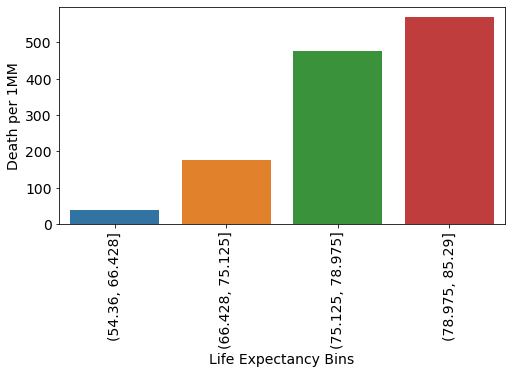

In [61]:
#rg.sort_values(inplace=True)
#plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 4))
sns.barplot(x = lf.index, y = lf)
plt.ylabel('Death per 1MM')
plt.xlabel('Life Expectancy Bins')
plt.xticks(rotation=90)
plt.savefig('life barplot.png', bbox_inches = 'tight')
plt.show()

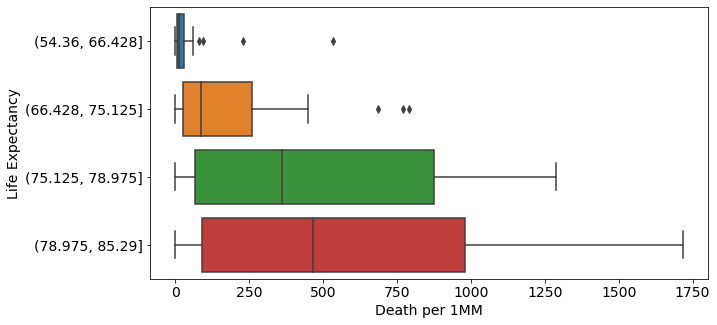

In [62]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 14})
sns.boxplot(x='dth1m', y='life_group', data=covid3).set(xlabel='Death per 1MM', 
                            ylabel='Life Expectancy')
plt.savefig('life boxplot.png', bbox_inches = 'tight')
plt.show()

In [63]:
covid2.describe()

,dth1m,Population,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy,y_pred
count,143.000000,1.430000e+02,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,329.115385,5.295428e+07,20819.860140,13407.979021,22.615385,27.426447,73.189091,178.869496
std,408.556845,1.708975e+08,21381.287786,17947.351346,21.281385,10.793744,7.673366,165.214941
min,0.200000,1.166399e+06,727.000000,293.000000,1.300000,12.331503,54.360000,5.115975
25%,18.500000,5.452154e+06,4355.000000,1559.000000,5.200000,17.158956,66.735000,36.547576
50%,105.000000,1.207187e+07,13463.000000,5387.000000,11.200000,26.185118,75.050000,136.720678
75%,481.500000,3.864667e+07,30784.500000,16146.500000,44.050000,37.272209,78.770000,246.936472
max,1716.000000,1.439324e+09,128647.000000,80296.000000,65.300000,49.842169,85.030000,666.982628


In [64]:
import statsmodels.api as sm
covid2 = covid.dropna()
covid2['le2'] = covid2['Life Expectancy']**2
X = covid2['le2'] 
Xc = sm.add_constant(X)
y = covid2['dth1m']
model = sm.OLS(y, Xc, axis=1).fit()
model.summary()

E:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dth1m   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     54.74
Date:                Sun, 10 Jan 2021   Prob (F-statistic):           1.13e-11
Time:                        15:52:02   Log-Likelihood:                -1038.8
No. Observations:                 143   AIC:                             2082.
Df Residuals:                     141   BIC:                             2087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -740.7259    147.494     -5.022      0.000   -1032.312    -449.140
le2            0.1976      0.027      7.399      0.000       0.145       0.250
==============================================================================
Omnibus:                       12.523   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.284
Skew:                           0.731   Prob(JB):                      0.00130
Kurtosis:                       3.305   Cond. No.                     2.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

E:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


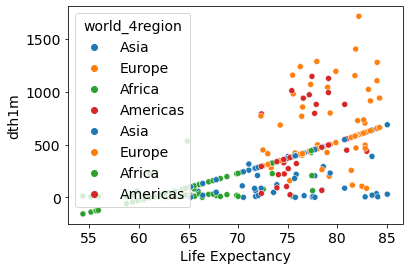

In [65]:
y_pred = model.predict(Xc)
covid2['y_pred'] = y_pred

sns.scatterplot(x='Life Expectancy', y='dth1m', hue='world_4region', data=covid2)
sns.scatterplot(x='Life Expectancy', y='y_pred', hue='world_4region', data=covid2)
plt.show()

In [66]:
cv = covid.sort_values(by='dth1m')

In [67]:
cv.head()

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy
20,Burundi,0.2,12071873.0,Africa,Sub_Saharan_Africa,735.0,293.0,55.8,45.400648,62.71
133,Taiwan,0.3,23839282.0,Asia,East_Asia_Pacific,54020.0,26910.0,NaN,NaN,81.04
135,Tanzania,0.3,60605147.0,Africa,Sub_Saharan_Africa,2948.0,975.0,55.8,43.843807,66.39
149,Vietnam,0.4,97793604.0,Asia,East_Asia_Pacific,6790.0,2366.0,11.5,23.213828,75.77
89,Mongolia,0.6,3305576.0,Asia,East_Asia_Pacific,12946.0,3672.0,9.7,30.798281,70.53


In [68]:
cv.tail(10)

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy
146,USA,1127.0,332013304.0,Americas,America,59928.0,59939.0,5.2,18.549317,79.11
108,Peru,1146.0,33209627.0,Americas,America,13463.0,6723.0,20.3,25.254496,77.44
143,UK,1153.0,68071770.0,Europe,Europe_Central_Asia,44920.0,39532.0,7.7,17.695701,81.77
18,Bulgaria,1158.0,6920971.0,Europe,Europe_Central_Asia,20948.0,8197.0,2.2,14.685379,75.49
33,Czechoslovakia,1194.0,10719354.0,Europe,Europe_Central_Asia,38020.0,20291.0,5.4,15.722950,79.85
100,North Macedonia,1239.0,2083329.0,Europe,Europe_Central_Asia,15290.0,5418.0,1.9,16.393603,76.26
66,Italy,1279.0,60415307.0,Europe,Europe_Central_Asia,40924.0,32038.0,4.9,13.166658,84.01
15,Bosnia and Herzegovina,1288.0,3270109.0,Europe,Europe_Central_Asia,13108.0,5387.0,1.8,14.693759,77.93
122,Slovenia,1405.0,2079087.0,Europe,Europe_Central_Asia,36387.0,23488.0,5.0,15.105640,81.85
12,Belgium,1716.0,11615913.0,Europe,Europe_Central_Asia,49367.0,43325.0,7.9,17.058203,82.17


In [80]:
cv = covid.sort_values(by='youth')

In [81]:
cv.head(10)

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy
120,Singapore,5.0,5874266.0,Asia,East_Asia_Pacific,94105.0,56746.0,22.7,12.331503,84.07
69,Japan,30.0,126273665.0,Asia,East_Asia_Pacific,42067.0,38214.0,12.7,12.573031,85.03
125,South Korea,21.0,51292237.0,Asia,East_Asia_Pacific,38824.0,29958.0,10.1,12.746444,83.50
66,Italy,1279.0,60415307.0,Europe,Europe_Central_Asia,40924.0,32038.0,4.9,13.166658,84.01
111,Portugal,734.0,10181138.0,Europe,Europe_Central_Asia,32554.0,21316.0,10.2,13.252085,82.65
112,Qatar,87.0,2807805.0,Asia,Middle_East_North_Africa,128647.0,61264.0,5.2,13.595900,80.73
50,Germany,468.0,83923689.0,Europe,Europe_Central_Asia,52556.0,44680.0,4.8,13.799488,81.88
52,Greece,495.0,10396357.0,Europe,Europe_Central_Asia,28583.0,19214.0,10.9,13.896599,82.80
7,Austria,727.0,9033158.0,Europe,Europe_Central_Asia,53879.0,47261.0,2.6,14.361858,82.05
59,Hungary,1070.0,9647507.0,Europe,Europe_Central_Asia,28799.0,14364.0,1.8,14.433220,77.31


In [84]:
cv.tail(30)

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy
67,Ivory Coast,5.0,26713623.0,Africa,Sub_Saharan_Africa,3945.0,1529.0,52.4,41.714703,58.75
55,Guinea-Bissau,23.0,1991902.0,Africa,Sub_Saharan_Africa,1704.0,737.0,62.1,42.153664,59.38
152,Zimbabwe,30.0,14974879.0,Africa,Sub_Saharan_Africa,2434.0,1548.0,54.6,42.158127,62.16
13,Benin,4.0,12286038.0,Africa,Sub_Saharan_Africa,2276.0,827.0,54.1,42.205519,62.84
21,Cameroon,17.0,26885072.0,Africa,Sub_Saharan_Africa,3722.0,1422.0,53.9,42.362131,60.32
0,Afghanistan,57.0,39379235.0,Asia,South_Asia,1976.0,538.0,36.4,42.472271,65.98
117,Senegal,26.0,16970172.0,Africa,Sub_Saharan_Africa,3458.0,1366.0,45.7,42.839869,68.87
54,Guinea,6.0,13315335.0,Africa,Sub_Saharan_Africa,2247.0,868.0,55.7,43.449989,62.64
82,Malawi,10.0,19383519.0,Africa,Sub_Saharan_Africa,1205.0,357.0,59.7,43.468688,65.62
99,Nigeria,6.0,208762568.0,Africa,Sub_Saharan_Africa,5887.0,1969.0,62.7,43.687530,55.75


In [71]:
cv = covid.sort_values(by='dth_cd')
cv.tail(20)

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy
119,Sierra Leone,10.0,8060553.0,Africa,Sub_Saharan_Africa,1530.0,504.0,57.9,40.724311,55.92
78,Liberia,16.0,5118771.0,Africa,Sub_Saharan_Africa,1285.0,699.0,58.5,40.752918,65.00
77,Lesotho,35.0,2151079.0,Africa,Sub_Saharan_Africa,2932.0,1233.0,59.3,32.466917,55.65
82,Malawi,10.0,19383519.0,Africa,Sub_Saharan_Africa,1205.0,357.0,59.7,43.468688,65.62
84,Mali,14.0,20549328.0,Africa,Sub_Saharan_Africa,2218.0,828.0,60.6,47.304697,60.54
151,Zambia,23.0,18647600.0,Africa,Sub_Saharan_Africa,4033.0,1535.0,60.6,44.462509,64.70
36,DRC,7.0,90953024.0,Africa,Sub_Saharan_Africa,889.0,462.0,61.7,46.001399,61.60
55,Guinea-Bissau,23.0,1991902.0,Africa,Sub_Saharan_Africa,1704.0,737.0,62.1,42.153664,59.38
98,Niger,5.0,24652377.0,Africa,Sub_Saharan_Africa,1019.0,376.0,62.7,49.842169,63.62
99,Nigeria,6.0,208762568.0,Africa,Sub_Saharan_Africa,5887.0,1969.0,62.7,43.687530,55.75


In [129]:
cv = covid.sort_values(by='Life Expectancy')

In [133]:
cv.head()

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy
23,CAR,13.0,4873126.0,Africa,Sub_Saharan_Africa,727.0,424.0,63.7,43.920016,54.36
24,Chad,6.0,16667091.0,Africa,Sub_Saharan_Africa,1945.0,657.0,63.4,46.820945,55.17
77,Lesotho,35.0,2151079.0,Africa,Sub_Saharan_Africa,2932.0,1233.0,59.3,32.466917,55.65
99,Nigeria,6.0,208762568.0,Africa,Sub_Saharan_Africa,5887.0,1969.0,62.7,43.687530,55.75
119,Sierra Leone,10.0,8060553.0,Africa,Sub_Saharan_Africa,1530.0,504.0,57.9,40.724311,55.92


In [135]:
cv.tail(20)

,Country,dth1m,Population,world_4region,world_6region,GDPpc_PPP,GDPpc_nominal,dth_cd,youth,Life Expectancy
45,Finland,105.0,5545215.0,Europe,Europe_Central_Asia,46344.0,45778.0,1.3,16.016342,82.48
111,Portugal,734.0,10181138.0,Europe,Europe_Central_Asia,32554.0,21316.0,10.2,13.252085,82.65
95,Netherlands,704.0,17154662.0,Europe,Europe_Central_Asia,54422.0,48796.0,5.2,15.883496,82.78
96,New Zealand,5.0,5002100.0,Asia,East_Asia_Pacific,40748.0,43415.0,4.6,19.566604,82.80
52,Greece,495.0,10396357.0,Europe,Europe_Central_Asia,28583.0,19214.0,10.9,13.896599,82.80
64,Ireland,465.0,4966398.0,Europe,Europe_Central_Asia,76745.0,69727.0,5.1,21.150375,82.81
101,Norway,86.0,5443283.0,Europe,Europe_Central_Asia,62183.0,75428.0,7.3,17.412975,82.94
22,Canada,437.0,37914109.0,Americas,America,46510.0,44841.0,5.6,15.845900,82.96
46,France,1023.0,65348904.0,Europe,Europe_Central_Asia,44033.0,39827.0,6.0,17.802158,83.13
130,Sweden,914.0,10132046.0,Europe,Europe_Central_Asia,51405.0,54075.0,5.2,17.625490,83.33
